In [1]:
!nvidia-smi

Mon Nov 15 09:23:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install optuna

In [15]:
import os
import optuna
import numpy as np
import pandas as pd
from optuna.trial import Trial
from optuna.samplers import TPESampler
from sklearn.model_selection import train_test_split
import IPython.display as ipd
import warnings

from matplotlib import pyplot as plt
from xgboost import XGBRegressor as Model
warnings.filterwarnings('ignore')
%matplotlib inline

In [5]:
# ===DATA===
PATH = '/content/drive/MyDrive/gh/kaggle/dacon/bicycle'
trainset = pd.read_csv(PATH + '/dataset/train.csv')
testset = pd.read_csv(PATH + '/dataset/test.csv')
submission = pd.read_csv(PATH + '/dataset/sample_submission.csv')

In [6]:
def humidex(tmp, hum):
    result = 0.81*tmp + 0.01*hum * (0.99* tmp - 14.3) + 46.3
    return result

def holiday_cat(week_day):
  if week_day in [6] :
    return 1
  else :
    return 0

def split_date(df):
    df['year'] = pd.to_datetime(df['date_time']).dt.year
    df['month'] = pd.to_datetime(df['date_time']).dt.month
    df['day'] = pd.to_datetime(df['date_time']).dt.day
    df['week'] = pd.to_datetime(df['date_time']).dt.week
    df['weekday'] = pd.to_datetime(df['date_time']).dt.weekday
    df['humidex'] = df.apply(lambda x : humidex(x['high_temp'], x['humidity']), axis=1)
    df['sun'] = df.apply(lambda x : holiday_cat(x['weekday']), axis = 1)
    df['ideal'] = df[['high_temp', 'wind_speed']].apply(lambda x: (0, 1)[x['high_temp'] > 24 and x['wind_speed'] < 30], axis = 1)
    return df.drop(columns=['date_time'])

In [7]:
traindf = split_date(trainset)
testdf = split_date(testset)

In [8]:
keys = traindf.drop(columns=['number_of_rentals']).keys()

In [9]:
keydict = dict()
for i, k in enumerate(keys):
    keydict[i]=k

In [10]:
SCALE = False

X = np.array(traindf.drop(columns=['number_of_rentals'])).astype(float)
y = np.array(traindf['number_of_rentals']).astype(float)
X_test = np.array(testdf).astype(float)

if SCALE:
    x_max = np.max(X, 0)
    y_max = np.max(y, 0)
    X /= x_max
    y /= y_max
    X_test /= x_max

In [11]:
def nmae(true, pred):
    return np.mean(np.abs(true-pred)/true)

In [12]:
def cv(model, X=X, y=y, cnt=100, test_size=.5):
    score = list()
    seeds = np.random.choice(np.arange(1e5), size=cnt, replace=False)
    for seed in seeds:
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=test_size)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_valid)
        if SCALE:
            y_pred *= y_max
            y_valid *= y_max
        score.append(nmae(y_valid, y_pred))
    return np.mean(score)

In [13]:
def select_features(X, cols):
    _X = list()
    for c in cols:
        _X.append(np.expand_dims(X[:, c],-1))
    return np.concatenate(_X, axis=1)

In [ ]:
def NMAE(true, pred):
    return np.mean(np.abs(true-pred) / true)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)
def objective(trial: Trial) -> float:
    params_xgb = {
        "tree_method":"gpu_hist",
        "gpu_id": 0,
        "silent": 1,
        "objective":"reg:squarederror",
        "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
        "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
    }
    if params_xgb["booster"] == "gbtree" or params_xgb["booster"] == "dart":
        params_xgb["max_depth"] = trial.suggest_int("max_depth", 1, 9)
        params_xgb["eta"] = trial.suggest_loguniform("eta", 1e-8, 1.0)
        params_xgb["gamma"] = trial.suggest_loguniform("gamma", 1e-8, 1.0)
        params_xgb["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if params_xgb["booster"] == "dart":
        params_xgb["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        params_xgb["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        params_xgb["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-8, 1.0)
        params_xgb["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-8, 1.0)   
    

    model = Model(**params_xgb)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        early_stopping_rounds=100,
        verbose=False,
    )

    xgb_pred = model.predict(X_valid)
    score = NMAE(y_valid, xgb_pred)
    
    return score

sampler = TPESampler(seed=42)
bc_study = optuna.create_study(
    study_name="xgb_parameter_opt",
    direction="minimize",
    sampler=sampler,
)
bc_study.optimize(objective, n_trials=150)
print("Best NMAE:", bc_study.best_value)
print("Best trial:", bc_study.best_trial.params)
print("Best trial:", bc_study.best_trial)

In [ ]:
min_loss = 1e10
min_cols = None

params = bc_study.best_trial.params
options = {'tree_method':'gpu_hist','gpu_id':0,"objective":"reg:squarederror"}
params.update(options)


for i in np.arange(start=0, stop=len(keys)):
    model = Model(**params)
    cols = np.arange(len(keys))
    cols = np.delete(cols, i)
    _X = select_features(X, cols)
    loss = cv(model, _X, y, cnt=30)
    if min_loss > loss:
        min_loss = loss
        min_cols = f"{keydict.get(i)}"
    print(f"{keydict.get(i)}, {loss:.4f} (min {min_loss:.4f})")

In [ ]:
for i in np.arange(start=0, stop=len(keys)-1):
    for j in np.arange(start=i+1, stop=len(keys)):
        model = Model(**params)
        cols = np.arange(len(keys))
        cols = np.delete(cols, [i,j])
        _X = select_features(X, cols)
        loss = cv(model, _X, y, cnt=30)
        if min_loss > loss:
            min_loss = loss
            min_cols = f"{keydict.get(i)}, {keydict.get(j)}"
        print(f"{keydict.get(i)}, {keydict.get(j)}, {loss:.4f} (min {min_loss:.4f})")

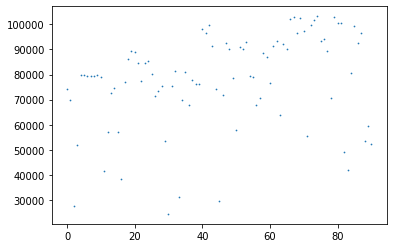

In [22]:
## best score params
# params = {'tree_method':'gpu_hist','gpu_id':0,"objective":"reg:squarederror",'booster': 'dart', 'lambda': 9.367121129908102e-08, 'alpha': 2.4923435220616885e-08, 'max_depth': 7, 'eta': 1.4853885138685323e-06, 'gamma': 8.53464226674219e-05, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.029695567573807306, 'skip_drop': 1.1540510640651016e-05}

params = bc_study.best_trial.params
options = {'tree_method':'gpu_hist','gpu_id':0,"objective":"reg:squarederror"}
params.update(options)
model = Model(**params)

cols = np.arange(len(keys))
cols = np.delete(cols, [0,7]) # drop columns
_X = select_features(X, cols)

model.fit(_X, y)

_X_test = select_features(X_test, cols)
y_pred = model.predict(_X_test)
if SCALE:
    y_pred *= y_max
y_pred = y_pred.astype(int)

In [ ]:
submission['number_of_rentals'] = y_pred
submission.to_csv(PATH + '/dataset/xgb_final.csv', index= False)